m.tortora@unicampus.it, PhD Student

## Overview

In this tutorial, we will cover:

1. Segmentation:
  * Image Thresholding:
    * Global thresholding
    * Otsu's method
    * Adaptive thresholding
  * Clustering:
    * k-Means
  * Model-driven segmentation:
    * Active Contour
    * Level Set


## Segmentation

Image Segmentation is the process of subdividing an image into its constituent regions or objects. In many computer vision applications, image segmentation is very useful to detect the region of interest. For instance, in medical imaging where we have to locate tumors, or in object detection like self-driving cars have to detect pedestrians, traffic signals, etc or for video surveillance, etc. There are a number of methods available to perform image segmentation. For instance, thresholding, clustering methods, graph partitioning methods, and convolutional methods to mention a few.

## Thresholding

Image thresholding is one of the simplest methods for image segmentation.
Image thresholding divides images directly into sub-regions based only on pixel intensity values.

**Concept**

If the pixel value is greater than a threshold value, it is assigned one value (maybe white), else it is assigned another value (maybe black).

In other words, if $f(x,y)$ is the input image then the segmented image $g(x,y)$ is given by:

$g(x,y)=\begin{cases} 1,\quad \text{if $f(x,y)>T$} \\ 0,\quad \text{Otherwise} \end{cases}$

where T is the threshold value.
If T remains constant over the entire image, then this is known as **global thresholding**.
When the value of T changes over the entire image or depends upon the pixel neighborhood, then this is known as **adaptive thresholding**.

**Global thresholding**

In global thresholding, each pixel value in the image is compared with a single (global) threshold value.

Thresholding is only guaranteed to work when a good contrast ratio between the region of interest and the background exists. Otherwise, the thresholding will not be able to fully detect the region of interest.

Let's see a simple implementation of the global thresholding

In [ ]:
def global_threshold(image, thres_value, val_high, val_low):
  img = image.copy()
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] > thres_value:
                img[i,j] = val_high # Let's assign a val_high to all the pixels greater than the threshold
            else:
                img[i,j] = val_low  # Let's assign a val_low to all the pixels smaller than the threshold
    return img

OpenCV implements the following method to perform the global thresholding:

`cv2.threshold(img, thresh, maxval, type)`

where:
* *img*: Input greyscale image (8-bit or 32-bit floating point)
* *thresh*: global threshold value
* *maxval*: maximum value to use with the `THRESH_BINARY` and `THRESH_BINARY_INV` thresholding types.
* *type*: Thresholding type (see [ThresholdTypes](https://https://docs.opencv.org/3.4.15/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576)).

See [here](https://https://docs.opencv.org/3.4.15/db/d8e/tutorial_threshold.html) for more information

(-0.5, 799.5, 399.5, -0.5)

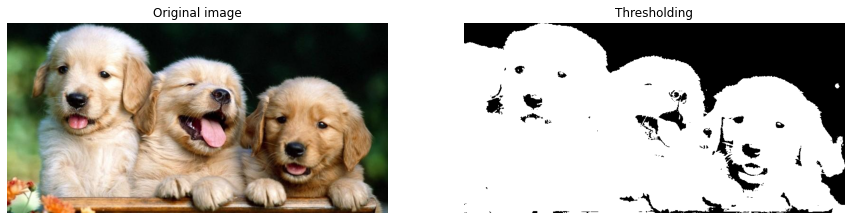

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load an image in the greyscale
img = cv2.imread('dog.png', 1) # Load an image in the greyscale mod

img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, img_bw = cv2.threshold(img_gs, 40, 255, cv2.THRESH_BINARY) # Threshold the image

# Plot results
f = plt.figure(figsize=(15,7))

f.add_subplot(1, 2, 1).set_title('Original image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

f.add_subplot(1, 2, 2).set_title('Thresholding')
plt.imshow(img_bw, cmap='gray')
plt.axis('off')

**How to find the correct threshold value?**

As we said above, the global threshold is a suitable approach only when the intensity distributions of the background and the ROI are sufficiently distinct.
In this case there is a clear valley between the two peaks of the histogram (one for the background and one for the foreground) and we can easily select the threshold value in that situation.

In case we have several images, we want an automatic method to estimate the threshold value for each image, we do not want to check the histogram of each image manually.

Let's have a look at the following iterative algorithm to find the threshold value for each image.

In [ ]:
import numpy as np

def thres_finder(img, init_thres=20, delta_T=1.0):
  # Let's divide the original image into two parts
  x_low, y_low = np.where(img<=init_thres) # Pixels values smaller than the threshold (background)
  x_high, y_high = np.where(img>init_thres) # Pixels values greater than the threshold (foreground)

  # Find the average pixel values of the two portions
  mean_low = np.mean(img[x_low, y_low])
  mean_high = np.mean(img[x_high, y_high])

  # Calculate the new threshold by averaging the two means
  new_thres = (mean_low + mean_high)/2

  # Stopping criteria
  if abs(new_thres-init_thres)< delta_T: # If the difference between the previous and
  # the new threshold is less than a certain value, you have found the threshold to be applied.
    return new_thres
  else: # Otherwiese, apply the new threshold to the original image.
    return thres_finder(img, init_thres=new_thres, delta_T=5.0)

Let's apply this algorithm

(-0.5, 799.5, 399.5, -0.5)

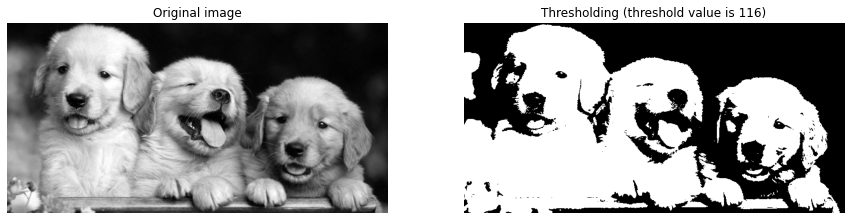

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load an image in the greyscale
img = cv2.imread('dog.png', 0) # Load an image in the greyscale mod

th = thres_finder(img, init_thres=125, delta_T=10.0)
ret, img_bw = cv2.threshold(img, th, 255, cv2.THRESH_BINARY) # Threshold the image

# Plot results
f = plt.figure(figsize=(15,7))

f.add_subplot(1, 2, 1).set_title('Original image')
plt.imshow(img, cmap='gray')
plt.axis('off')

f.add_subplot(1, 2, 2).set_title(f'Thresholding (threshold value is {int(th)})')
plt.imshow(img_bw, cmap='gray')
plt.axis('off')

**Optimum Global Thresholding using Otsu’s Method**

Otsu's method is another method for finding the global threshold.

In simple terms, Otsu’s method tries to find a threshold value which minimizes the weighted within-class variance. Since Variance is the spread of the distribution about the mean. Thus, minimizing the within-class variance will tend to make the classes compact.

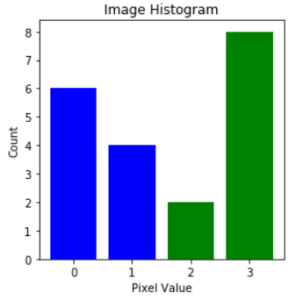

Let’s say we threshold a histogram at a value $T$. This produces two regions – left and right of $T$ whose variance is given by $\sigma^2_0$ and $\sigma^2_1$. Then the weighted within-class variance is given by:

$\sigma^2_\omega(T)=\omega_0(T)\sigma^2_0(T)+\omega_1(T)\sigma^2_1 (T)$

where $\omega_0(T)$ and $\omega_1(T)$ are the weights given to each class. Weights are total pixels in a thresholded region (left or right) divided by the total image pixels. Let’s take a simple example to understand how to calculate these.

we will iterate over all the possible threshold values, calculate the weighted within-class variance for each of the thresholds. The optimum threshold will be the one with the minimum within-class variance.

**Note**: This method assumes that the image histogram is bimodal and a reasonable contrast ratio exists between the background and the region of interest.

(-0.5, 799.5, 399.5, -0.5)

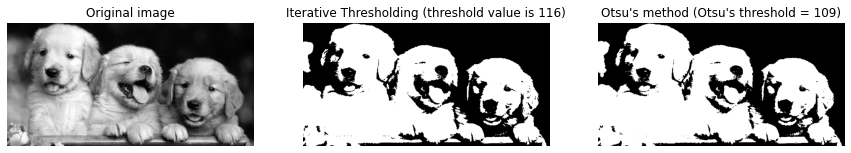

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load an image in the greyscale
img = cv2.imread('dog.png', 0) # Load an image in the greyscale mod

# Apply iterative thresholding method
th = thres_finder(img, init_thres=125, delta_T=10.0)
ret, img_bw1 = cv2.threshold(img, th, 255, cv2.THRESH_BINARY) # Threshold the image

# Applying Otsu's method setting the flag value into cv.THRESH_OTSU
otsu_th, img_bw2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Plot results
f = plt.figure(figsize=(15,7))

f.add_subplot(1, 3, 1).set_title('Original image')
plt.imshow(img, cmap='gray')
plt.axis('off')

f.add_subplot(1, 3, 2).set_title(f'Iterative Thresholding (threshold value is {int(th)})')
plt.imshow(img_bw1, cmap='gray')
plt.axis('off')

f.add_subplot(1, 3, 3).set_title(f'Otsu\'s method (Otsu\'s threshold = {int(otsu_th)})')
plt.imshow(img_bw2, cmap='gray')
plt.axis('off')

**Adaptive Thresholding**

As we said above, the global thresholding is not suitable for images with non-uniform illumination.

Adaptive thresholding works well for images with non-uniform illumination.
In this, the threshold value is calculated separately for each pixel using some statistics obtained from its neighborhood.
This way we will get different thresholds for different image regions and thus tackles the problem of varying illumination.

The whole procedure can be summed up as:
* For each pixel in the image calculate the statistics (such as mean, median, etc.) from its neighborhood. This will be the threshold value for that pixel.
* Compare the pixel value with this threshold

OpenCV implements the following method:

`cv2.adaptiveThreshold(img, maxValue, adaptiveMethod, thresholdType, blockSize, C)`

where:
* *img*: 8-bit greyscale input image.
* *maxValue*: This is the value assigned to the pixels after thresholding.
* *adaptiveMethod*: Adaptive thresholding algorithm to use, see [AdaptiveThresholdTypes](https://https://docs.opencv.org/4.5.3/d7/d1b/group__imgproc__misc.html#gaa42a3e6ef26247da787bf34030ed772c).
* *thresholdType*: Thresholding type that must be either THRESH_BINARY or THRESH_BINARY_INV, see [ThresholdTypes](https://https://docs.opencv.org/4.5.3/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576).
* *blockSize*: Size of a pixel neighborhood that is used to calculate a threshold value for the pixel: 3, 5, 7, and so on.
* *C*: Constant subtracted from the mean or weighted mean (see the details below). Normally, it is positive but may be zero or negative as well.


(-0.5, 2711.5, 3611.5, -0.5)

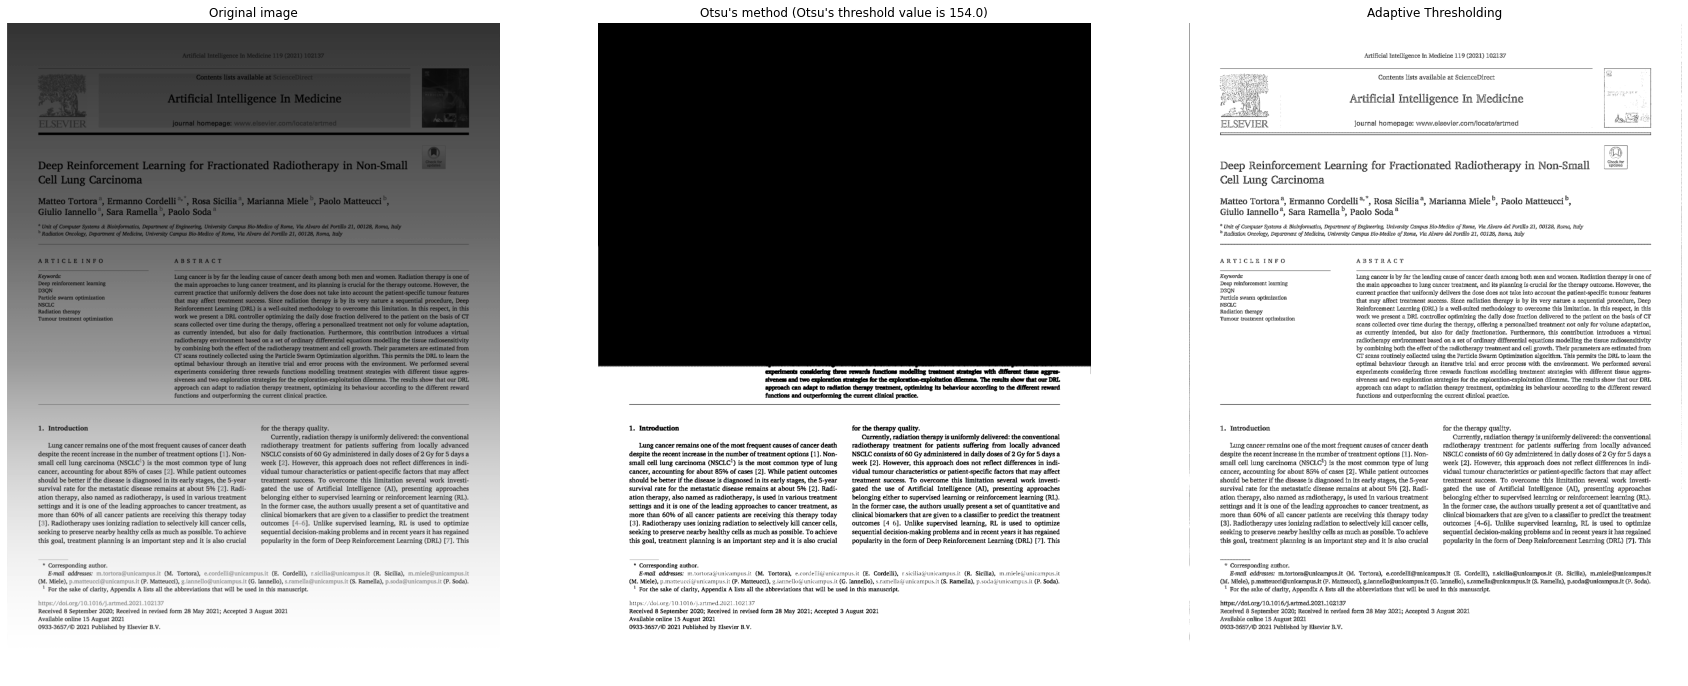

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load an image in the greyscale
img = cv2.imread('doc.png', 0) # Load an image in the greyscale mod

# Applying Otsu's method setting the flag value into cv.THRESH_OTSU
otsu_th, img_bw1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Applying Adaptive thresholding
img_bw2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)
# cv2.ADAPTIVE_THRESH_GAUSSIAN_C: he threshold value is the weighted sum of the
# neighborhood area. This uses Gaussian weights computed using getGaussiankernel() method.

# Plot results
f = plt.figure(figsize=(30,30))

f.add_subplot(1, 3, 1).set_title('Original image')
plt.imshow(img, cmap='gray')
plt.axis('off')

f.add_subplot(1, 3, 2).set_title(f'Otsu\'s method (Otsu\'s threshold value is {otsu_th})')
plt.imshow(img_bw1, cmap='gray')
plt.axis('off')

f.add_subplot(1, 3, 3).set_title('Adaptive Thresholding')
plt.imshow(img_bw2, cmap='gray')
plt.axis('off')

Unlike global thresholding, adaptive thresholding succeeds in highlighting fine details.

(-0.5, 799.5, 399.5, -0.5)

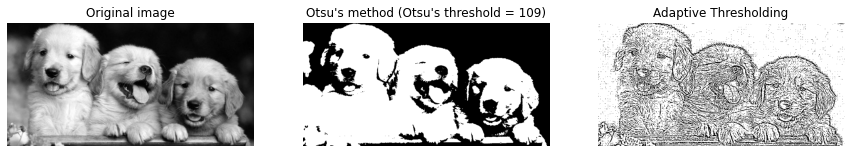

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load an image in the greyscale
img = cv2.imread('dog.png', 0) # Load an image in the greyscale mod

# Applying Otsu's method setting the flag value into cv.THRESH_OTSU
otsu_th, img_bw1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply Adaptive thresholding method
img_bw2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)

# Plot results
f = plt.figure(figsize=(15,7))

f.add_subplot(1, 3, 1).set_title('Original image')
plt.imshow(img, cmap='gray')
plt.axis('off')

f.add_subplot(1, 3, 2).set_title(f'Otsu\'s method (Otsu\'s threshold = {int(otsu_th)})')
plt.imshow(img_bw1, cmap='gray')
plt.axis('off')

f.add_subplot(1, 3, 3).set_title('Adaptive Thresholding')
plt.imshow(img_bw2, cmap='gray')
plt.axis('off')

## Clustering-based approaches

**K-means**

K-Means clustering algorithm is an unsupervised algorithm and it is used to segment the interest area from the background. It clusters, or partitions the given data into K-clusters or parts based on the K-centroids.

OpenCV implements the following method:

`cv2.kmeans(samples, k, criteria, attempts, flags)`

where:
* *samples*: It should be of np.float32 data type, and each feature should be put in a single column.
* *k*: Number of clusters to split the set by.
* *criteria*: It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops. Actually, it should be a tuple of 3 parameters. They are `( type, max_iter, epsilon )`:
  * *type*: type of termination criteria.
  * *max_iter*: An integer specifying maximum number of iterations.
  * *epsilon*: Required accuracy.
* *attempts*: Flag to specify the number of times the algorithm is executed using different initial labellings. The algorithm returns the labels that yield the best compactness
* *flags*: 	Flag that can take values of [cv::KmeansFlags](https://cv::KmeansFlags).

**Output parameters**:
* *compactness*: It is the sum of squared distance from each point to their corresponding centers.
* *labels* : This is the label array where each element marked ‘0’, ‘1’... k .
* *centers*: This is array of centers of clusters.

(-0.5, 1919.5, 1079.5, -0.5)

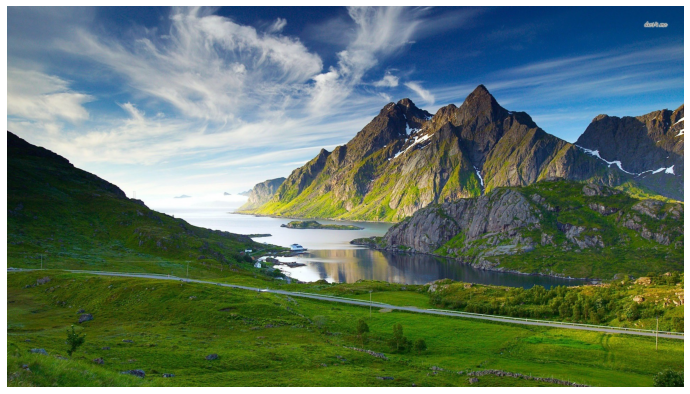

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load an image in the greyscale
img = cv2.imread('landscape.png', 1) # Load an image in the BGR mod
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot original image
f = plt.figure(figsize=(15,7))

plt.imshow(img)
plt.axis('off')

Let's plot the image into the RGB space

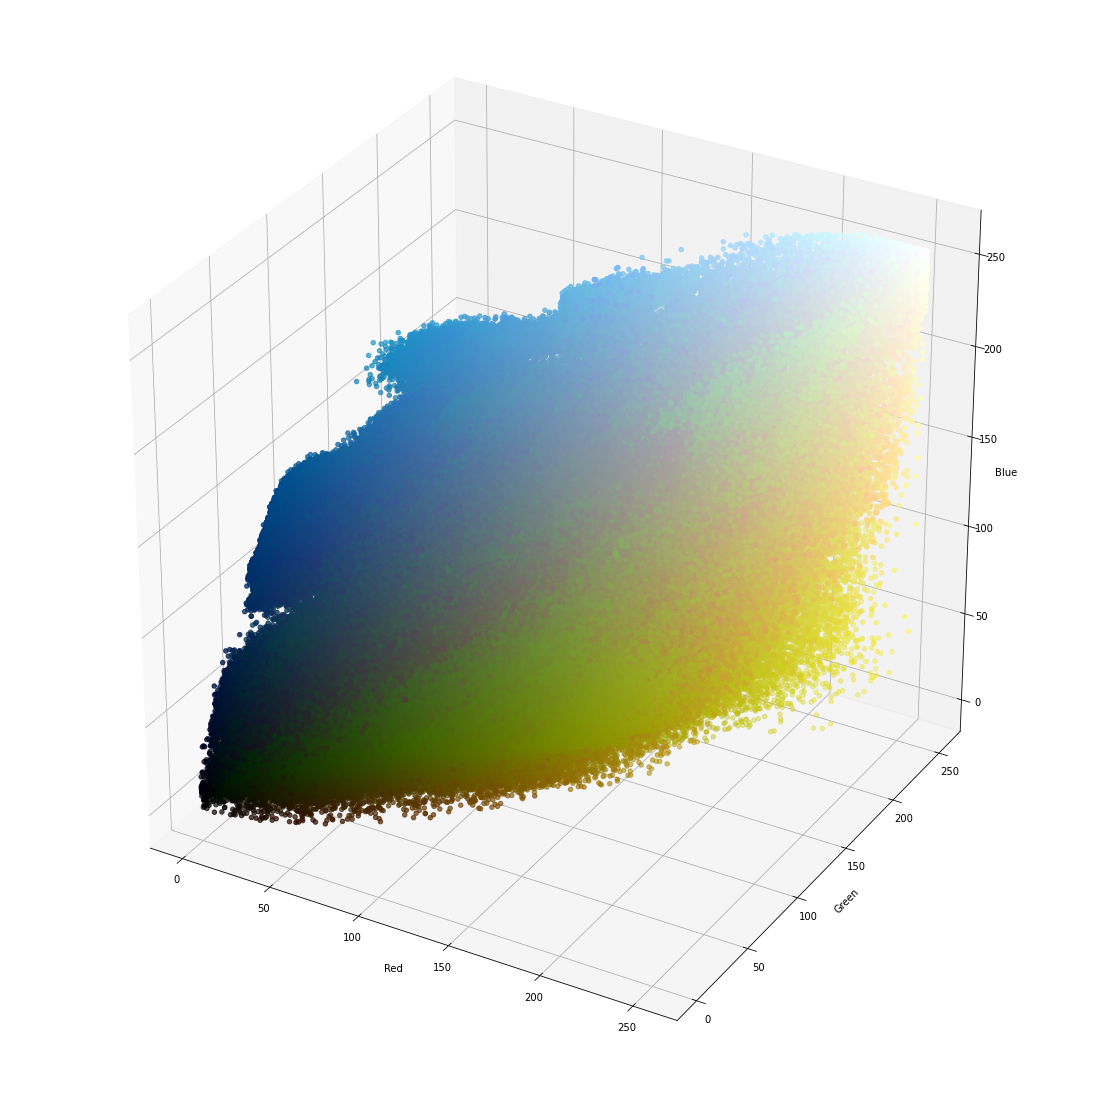

In [ ]:
r, g, b = cv2.split(img)

r = r.flatten()
g = g.flatten()
b = b.flatten()

pixels_values = img.reshape((-1,3)) # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
pixels_values = np.float32(pixels_values) # convert to np.float32

# Plot original image into the RGB space
f = plt.figure(figsize=(15,15))
ax = Axes3D(f)

ax.scatter(r, g, b, c = pixels_values/255)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()

Let's define a function to compute quantization with k-means

In [ ]:
def kmeans_segmentation(img, k):
  '''
  img: input image
  k: Number of clusters to split the set by.
  '''
  # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
  samples = img.copy()
  samples = samples.reshape((-1,3))

  # convert to np.float32
  samples = np.float32(samples)

  # define criteria (type, max_iter, epsilon)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

  # apply k-means
  ret, label, center = cv2.kmeans(samples, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

  # Now convert back into uint8, and make original image
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((img.shape))

  return res2

(-0.5, 1919.5, 1079.5, -0.5)

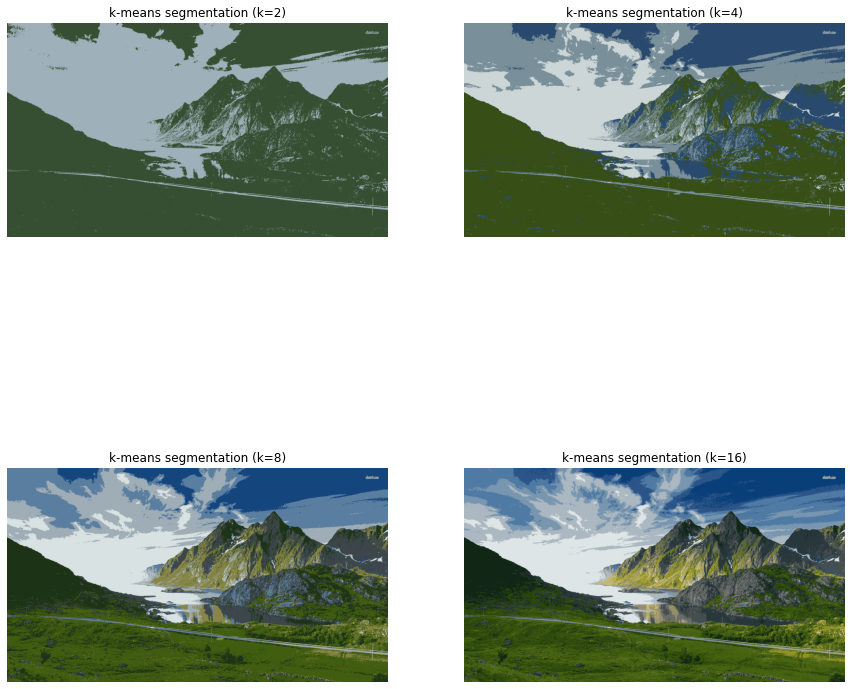

In [ ]:
# Plot results
f = plt.figure(figsize=(15,15))

f.add_subplot(2, 2, 1).set_title('k-means segmentation (k=2)')
plt.imshow(kmeans_segmentation(img, 2))
plt.axis('off')

f.add_subplot(2, 2, 2).set_title('k-means segmentation (k=4)')
plt.imshow(kmeans_segmentation(img, 4))
plt.axis('off')

f.add_subplot(2, 2, 3).set_title('k-means segmentation (k=8)')
plt.imshow(kmeans_segmentation(img, 8))
plt.axis('off')

f.add_subplot(2, 2, 4).set_title('k-means segmentation (k=16)')
plt.imshow(kmeans_segmentation(img, 16))
plt.axis('off')

# Active Contour

**Active contours**, also knows as **snakes**, are means of model-driven segmentation.

Their use enforces closed and smooth boundaries for each segmentation irrespective of the image content.

The active contour model is a method to fit open or closed splines to lines or edges in an image.

A snake is an energy minimizing, deformable spline influenced by constraint and image forces that pull it towards object contours and internal forces that resist deformation

***It works by minimising an energy that is in part defined by the image and part by the spline’s shape: length and smoothness. The minimization is done implicitly in the shape energy and explicitly in the image energy.***

Typically it is a good idea to smooth images a bit before analyzing, as done in the following examples.


**Main features**:
* It represents an object boundary or some other salient image feature as a parametric curve
* An energy functional E is associated with the curve
* The problem of finding object boundary is cast as an energy minimization problem

**How snakes work**
1. A higher-level process or a user initializes any curve close to the object boundary
2. The snake then starts deforming and moving towards the desired object boundary
3. In the end it completely “shrink-wraps” around the object


Snakes do not solve the entire problem of finding contours in images, **since the method requires knowledge of the desired contour shape beforehand**. Rather, they depend on other mechanisms such as **interaction with a user**, interaction with some higher level image understanding process, or **information from image data adjacent in time or space**.


Scikit-image implements the following method:

`active_contour(image, snake, alpha=0.01, beta=0.1, w_line=0, w_edge=1, gamma=0.01, max_px_move=1.0, max_num_iter=2500, convergence=0.1, *, boundary_condition='periodic', coordinates='rc')`

where:

* *img*: Input image.
* *snake*: Initial snake coordinates. For periodic boundary conditions, endpoints must not be duplicated.
* *alpha*: Snake length shape parameter. Higher values makes snake contract faster.
* *beta*: Snake smoothness shape parameter. Higher values makes snake smoother.
* *w_line*: Controls attraction to brightness. Use negative values to attract toward dark regions.
* *w_edge*: Controls attraction to edges. Use negative values to repel snake from edges.
* *gamma*: Explicit time stepping parameter.
* *max_px_move*: Maximum pixel distance to move per iteration.
* *max_num_iter*: Maximum iterations to optimize snake shape.
* *convergence*: Convergence criteria.
* *boundary_condition*: Boundary conditions for the contour. Can be one of ‘periodic’, ‘free’, ‘fixed’, ‘free-fixed’, or ‘fixed-free’. ‘periodic’ attaches the two ends of the snake, ‘fixed’ holds the end-points in place, and ‘free’ allows free movement of the ends. ‘fixed’ and ‘free’ can be combined by parsing ‘fixed-free’, ‘free-fixed’. Parsing ‘fixed-fixed’ or ‘free-free’ yields same behaviour as ‘fixed’ and ‘free’, respectively.
* *coordinates*: This option remains for compatibility purpose only and has no effect. It was introduced in 0.16 with the 'xy' option, but since 0.18, only the 'rc' option is valid. Coordinates must be set in a row-column format.

See [here](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.active_contour) for more information

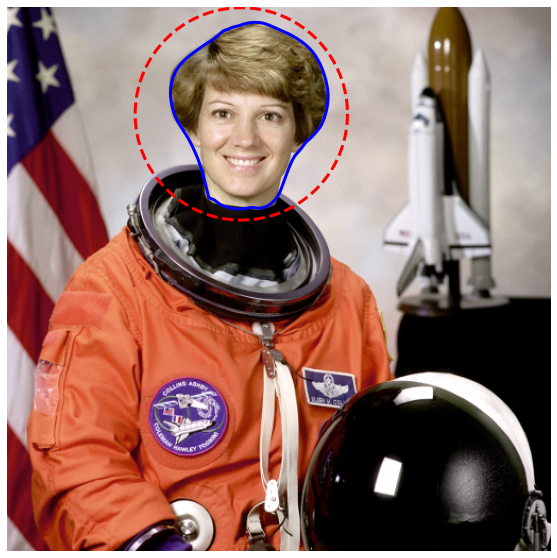

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import cv2

img = cv2.imread("astronaut.png", 1) # Upload grayscale image
img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gf = cv2.GaussianBlur(img_gs, (9,9), 9) # Apply Gaussian filter to smooth the image

# Let's initialize a circle around the astronaut’s face
s = np.linspace(0, 2*np.pi, 400)
r = 100 + 100*np.sin(s)
c = 220 + 100*np.cos(s)
init = np.array([r, c]).T

# Let's apply Active Contout
snake = active_contour(img_gf, init, alpha=0.015, beta=10, gamma=0.001)
# The default parameters w_line=0, w_edge=1 will make the curve search towards edges,
# such as the boundaries of the face.


# Plot results
f = plt.figure(figsize=(15,10))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.plot(init[:, 1], init[:, 0], '--r', lw=3)
plt.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
plt.show()

# Level Set

**Chan-Vese Segmentation**

The Chan-Vese segmentation algorithm is designed to segment objects without clearly defined boundaries. This algorithm is based on level sets that are evolved iteratively to minimize an energy, which is defined by weighted values corresponding to the sum of differences intensity from the average value outside the segmented region, the sum of differences from the average value inside the segmented region, and a term which is dependent on the length of the boundary of the segmented region.

Scikit-image implements the following method:

`chan_vese(img, mu=0.25, lambda1=1.0, lambda2=1.0, tol=0.001, dt=0.5, init_level_set='checkerboard', extended_output=False)`

where:

* *img*: Grayscale image to be segmented.
* *mu*: ‘edge length’ weight parameter. Higher mu values will produce a ‘round’ edge, while values closer to zero will detect smaller objects.
* *lambda1*: ‘difference from average’ weight parameter for the output region with value ‘True’. If it is lower than lambda2, this region will have a larger range of values than the other.
* *lambda2*: ‘difference from average’ weight parameter for the output region with value ‘False’. If it is lower than lambda1, this region will have a larger range of values than the other.
* *tol*: Level set variation tolerance between iterations. If the L2 norm difference between the level sets of successive iterations normalized by the area of the image is below this value, the algorithm will assume that the solution was reached.
* *dt*: A multiplication factor applied at calculations for each step, serves to accelerate the algorithm. While higher values may speed up the algorithm, they may also lead to convergence problems.
* *init_level_set*: Defines the starting level set used by the algorithm. If a string is inputted, a level set that matches the image size will automatically be generated. Alternatively, it is possible to define a custom level set, which should be an array of float values, with the same shape as ‘image’. Accepted string values are as follows.
* *extended_output*: If set to True, the return value will be a tuple containing the three return values (see below). If set to False which is the default value, only the ‘segmentation’ array will be returned.


See [here](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.chan_vese) for more information

(-24.950000000000003, 523.95, 6659.809690291746, 10426.465597592907)

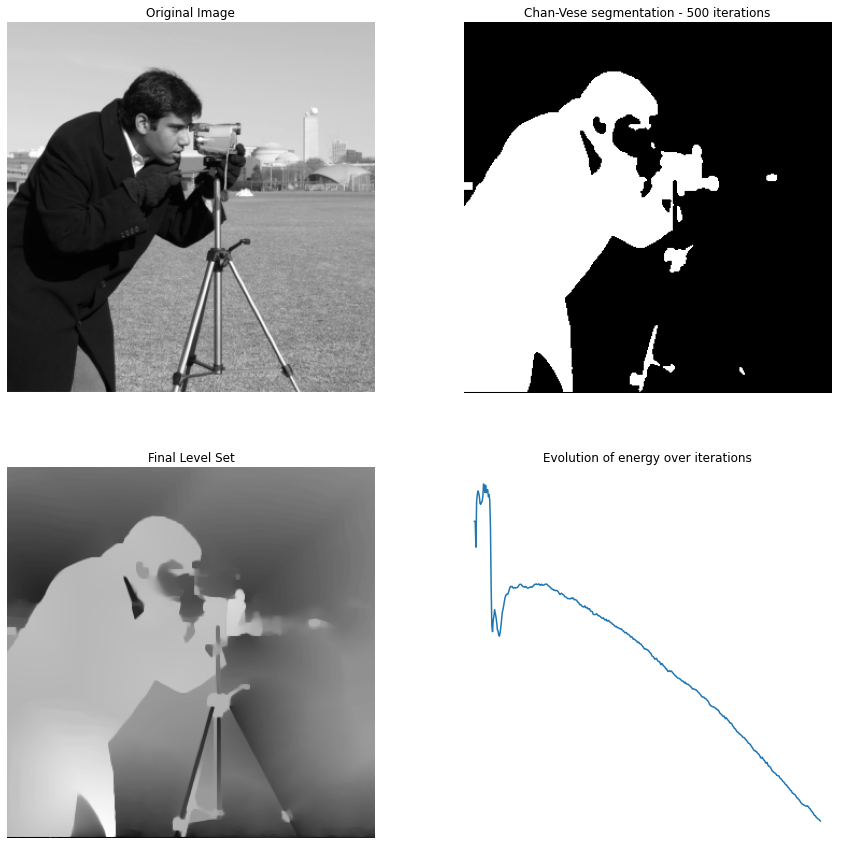

In [ ]:
import matplotlib.pyplot as plt
import cv2
from skimage.segmentation import chan_vese

img = cv2.imread("man.png", 0) # Load grayscale image
#img = img.astype("float")

# Apply Chan-Vese Segmentation algorithm
cv = chan_vese(img, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, dt=0.5,
               init_level_set="checkerboard", extended_output=True)

# Plot results
f = plt.figure(figsize=(15,15))

f.add_subplot(2, 2, 1).set_title('Original Image')
plt.imshow(img, cmap="gray")
plt.axis('off')

f.add_subplot(2, 2, 2).set_title(f'Chan-Vese segmentation - {len(cv[2])} iterations')
plt.imshow(cv[0], cmap="gray")
plt.axis('off')

f.add_subplot(2, 2, 3).set_title('Final Level Set')
plt.imshow(cv[1], cmap="gray")
plt.axis('off')

f.add_subplot(2, 2, 4).set_title('Evolution of energy over iterations')
plt.plot(cv[2])
plt.axis('off')